In [1957]:
import pandas as pd
import numpy as np



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [1958]:
#Load dataset into a pandas dataframe
data = pd.read_csv("../data/Cleaned data/data.csv") 

data.dropna(inplace = True)



data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,32.2,21.95,38.472917,6665.366167,23.465,01-2016,4,0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,21.7,21.00,36.907292,6236.849955,23.465,01-2016,5,1
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,10.3,21.55,31.997083,6551.924748,23.465,01-2016,6,1
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,6.4,20.90,33.424583,6729.993123,23.465,01-2016,0,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,4.4,19.05,33.053958,7333.898202,23.465,01-2016,1,0


In [1959]:

df = data.drop(['MIN','MAX', 'MONTHDATE','WEEKEND'], axis=1)


df.head()



,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,WEEKDAY
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,6665.366167,23.465,4
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,6236.849955,23.465,5
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,6551.924748,23.465,6
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,6729.993123,23.465,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,7333.898202,23.465,1


In [1960]:
# Onehot Encoding for categorial data (Weekday)


# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']].reset_index(drop=True)


# Create a one-hot encoder object

encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df_encoded = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']).reset_index(drop=True)


#Drop weekday column
df = df.drop(['WEEKDAY'], axis=1)


# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df.reset_index(drop=True), weekday_df_encoded], axis=1)


df.head()


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,6665.366167,23.465,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,6236.849955,23.465,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,6551.924748,23.465,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,6729.993123,23.465,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,7333.898202,23.465,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1961]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

print(df.columns)


Index(['YEAR', 'MONTH', 'DAY', 'HUMIDITY', 'WINDSPEED', 'TOTALDEMAND',
       'HOLIDAY', 'SOLAR', 'TEMPAVE', 'RRP', 'FORECASTDEMAND', 'OUTPUT', 'MON',
       'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'],
      dtype='object')


In [1962]:
# Split the dataset into training and testing sets. 

df_train = df[(df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1))]
df_test = df[df.index >= datetime(2021, 8, 1)]



df_train.drop(['FORECASTDEMAND'], axis=1)
df_test.drop(['FORECASTDEMAND'], axis=1)

train_X = df_train.drop('TOTALDEMAND', axis=1)
train_y = df_train['TOTALDEMAND']

test_X = df_test.drop('TOTALDEMAND', axis=1)
test_y = df_test['TOTALDEMAND']

print("number of training records",len(train_X))
print("number of test records",len(test_X))

X_train = train_X.values
y_train = train_y.values

X_test = test_X.values
y_test = test_y.values


# save for plotting later
demand_train_df = df_train[['TOTALDEMAND','FORECASTDEMAND']]
demand_test_df = df_test[['TOTALDEMAND','FORECASTDEMAND']]



number of training records 1417
number of test records 334


In [1963]:
# Normalize the data

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("X_train_scaled:", len(X_train_scaled))
print("X_test_scaled:", len(X_test_scaled))

scaler_Y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1))

print("y_train_scaled:", len(y_train_scaled))
print("y_test_scaled:", len(y_test_scaled))


X_train_scaled: 1417
X_test_scaled: 334
y_train_scaled: 1417
y_test_scaled: 334


In [1964]:
#Reshape the data for input to the LSTM model
#(This step is fit the data to 3D tensor format for LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#using sliding window approach to create input-output pairs with timesteps n = 1




X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(y_train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(y_test_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))





print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)



X_train:  (1416, 1, 18)
y_train:  (1416, 1)
X_test:  (333, 1, 18)
y_test:  (333, 1)


In [ ]:
# Build the LSTM model with three LSTM layers and one Dense output layer


model = Sequential()
model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=16, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))


optimizer = Adam(learning_rate=0.001)
#model.compile(loss='mean_squared_error', optimizer=optimizer)

model.compile(loss='mean_absolute_error', optimizer=optimizer)


In [1954]:

# Traing the LSTM model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
45/45 [==============================] - 7s 34ms/step - loss: 0.3214 - val_loss: 0.1524
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 0.1589 - val_loss: 0.1629
Epoch 3/50
45/45 [==============================] - 0s 9ms/step - loss: 0.1418 - val_loss: 0.1395
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 0.1217 - val_loss: 0.1441
Epoch 5/50
45/45 [==============================] - 0s 8ms/step - loss: 0.1103 - val_loss: 0.1107
Epoch 6/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0994 - val_loss: 0.0868
Epoch 7/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0951 - val_loss: 0.0794
Epoch 8/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0915 - val_loss: 0.0769
Epoch 9/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0936 - val_loss: 0.0772
Epoch 10/50
45/45 [==============================] - 0s 10ms/step - loss: 0.0862 - val_loss: 0.0745
Epoch 11/50
45/45

In [1955]:
# Make predictions on the test set
y_pred = model.predict(X_test)

print("y_test: ", y_test.shape)



y_test:  (333, 1)


In [1956]:
# Calculate MSE, MAE and R-squared

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: %.4f' % mse)
print('MAE: %.4f' % mae)
print('R-squared: %.4f' % r2)

MSE: 0.0077
MAE: 0.0653
R-squared: 0.7738


Plot Accuracy

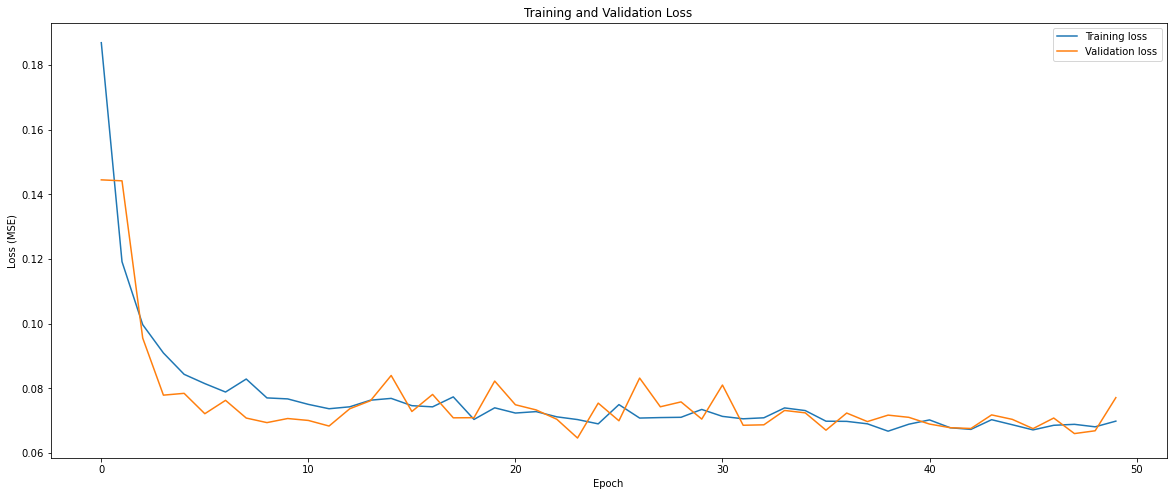

In [1944]:
# Plot training and validation loss (MSE) for each epoch

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [1938]:
# revert the predicted values to actual values
y_pred_reverted = scaler_Y.inverse_transform(y_pred)

y_pred_reverted = list(y_pred_reverted.flatten())
y_pred_reverted.insert(0, np.nan)

In [ ]:

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

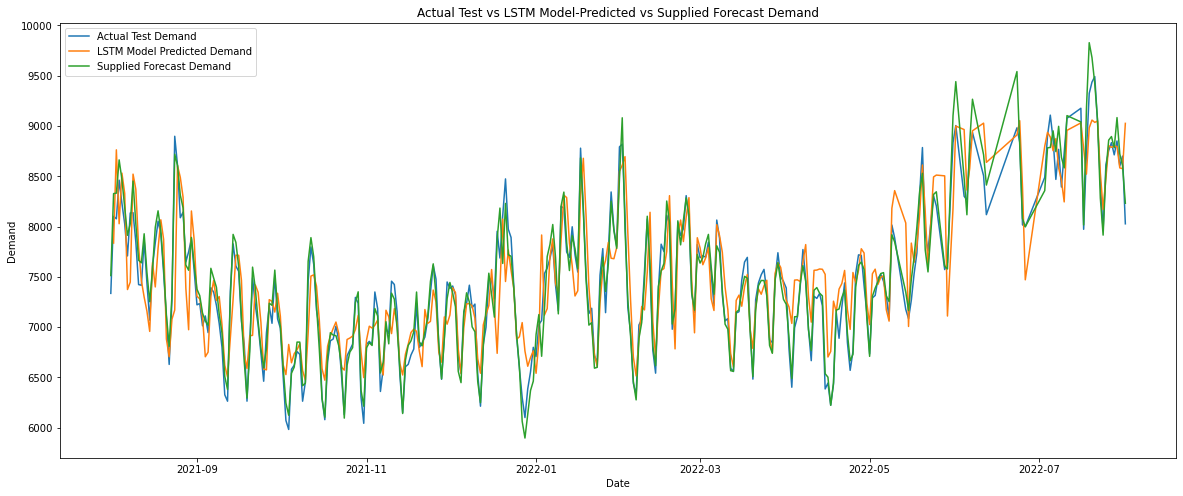

In [1939]:
# Plot Predicted Demand vs Actual Demand and Supplied Forecast Demand for the 5 years period

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('Actual Test vs LSTM Model-Predicted vs Supplied Forecast Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()